In [1]:
!pip install pulp
!pip install yfinance

In [2]:
!pip install cvxpy
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp
import scipy.linalg as la
import yfinance as yf

In [6]:
!pip install PyPortfolioOpt

In [9]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting

## how we load data from yahoo finance

#### Stock data

In [10]:
T = 1  # Number of days in time period
R = []
assets = ["AAPL", "EA", "MSFT", "NFLX", "GOOGL", "TSLA"]

for stock in assets:
    data = yf.Ticker(stock)
    # 我先改成1年， 这个之后可以随时改成想要的时段
    df = data.history(period="1y")

    # close values on that day
    close = df["Close"].values

    # convert day to day close values to return
    returns = (close[T:] - close[:-T]) / close[:-T]
    R.append(returns)

R = np.array(R).T
log_R = np.log(R)
r = np.mean(R, axis=0)
S = np.cov(R.T)

/tmp/ipykernel_944/733729607.py:18: RuntimeWarning: divide by zero encountered in log
  log_R = np.log(R)
/tmp/ipykernel_944/733729607.py:18: RuntimeWarning: invalid value encountered in log
  log_R = np.log(R)


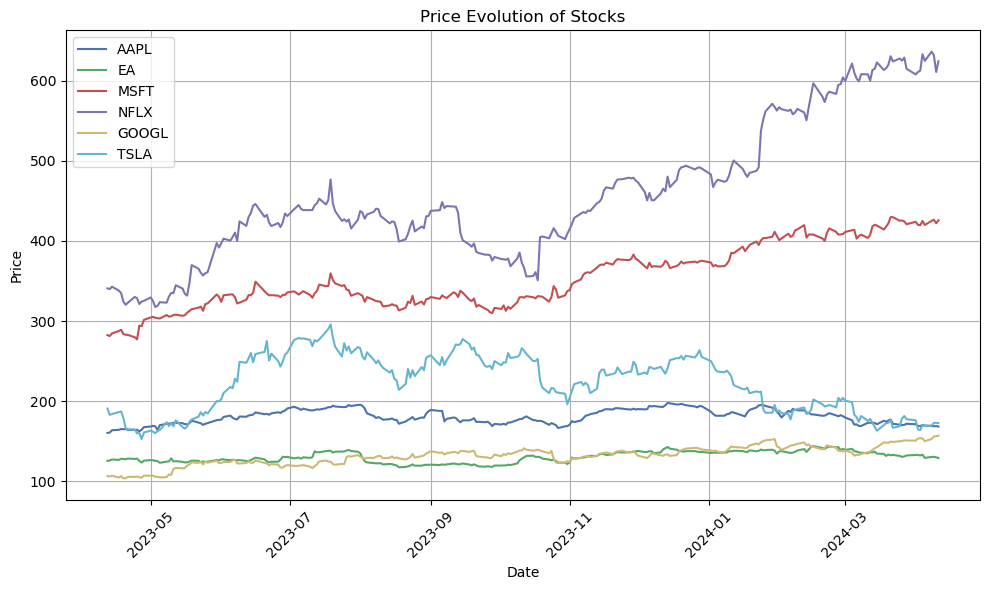

In [12]:
# Create a single plot for all stocks
plt.figure(figsize=(10, 6))

# Plot price evolution of each stock
for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    plt.plot(df.index, df["Open"], label=stock)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price Evolution of Stocks")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

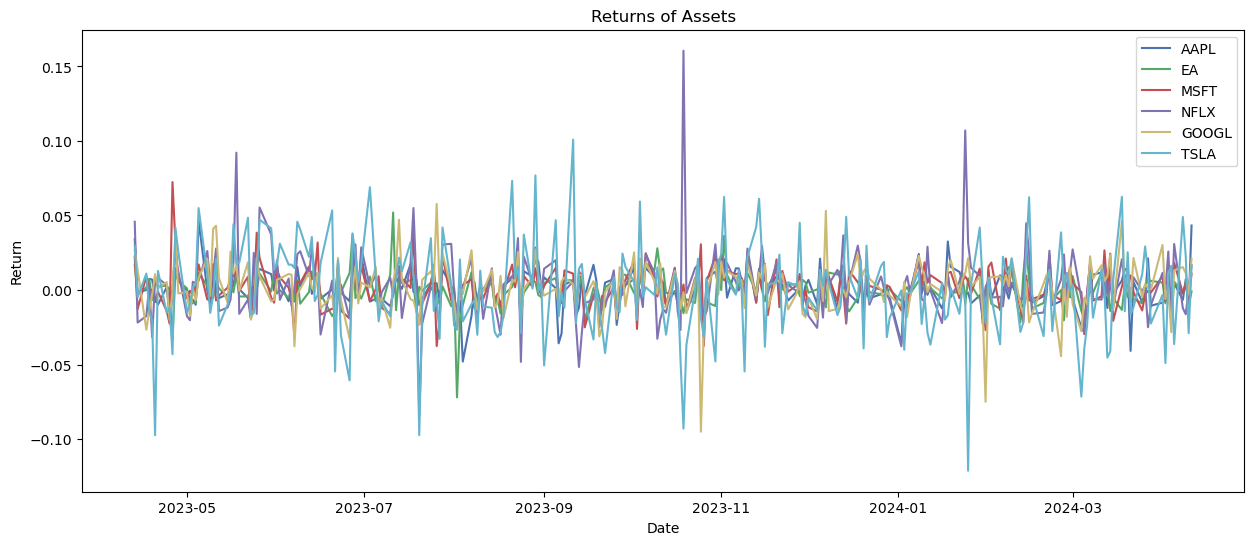

In [13]:
# Assuming df contains the date information in the index
dates = df.index[T:]

# Plot returns against date for each asset
plt.figure(figsize=(15, 6))
for i, asset in enumerate(assets):
    plt.plot(dates, R[:, i], label=asset)

plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Returns of Assets')
plt.legend()
plt.show()

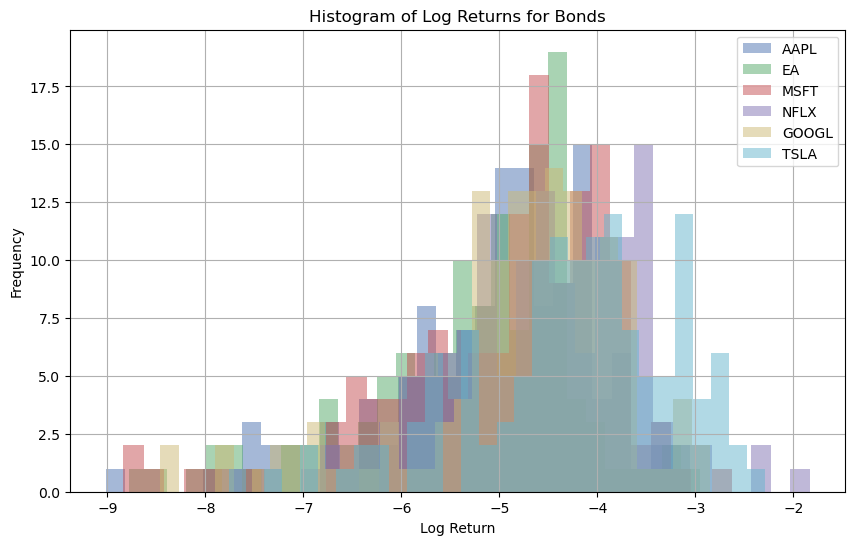

In [14]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for each bond
for i, bond in enumerate(assets):
    # Filter out non-finite values
    valid_log_R = log_R[:, i][np.isfinite(log_R[:, i])]
    # Plot histogram
    ax.hist(valid_log_R, bins=30, alpha=0.5, label=bond)

# Set labels and title
ax.set_xlabel('Log Return')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Log Returns for Bonds')
# Add legend
ax.legend()
# Display grid
ax.grid(True)
# Show plot
plt.show()

# We consider risk as MAD first, all these models are model 1x




# model 1A
when we minimize MAD under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
&  \sum_j x_j r_j = r_0 \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [19]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
r0 = 0.0008
print(n, T, r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += lpSum(r[j] * x[j] for j in range(n)) == r0

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

6 251 0.0008
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a6c3ce1faee7470e8c23c17a812f35c9-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/a6c3ce1faee7470e8c23c17a812f35c9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 4287 RHS
At line 4792 BOUNDS
At line 4793 ENDATA
Problem MODEL has 504 rows, 257 columns and 3526 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 444 (-60) rows, 257 (0) columns and 3106 (-420) elements
Perturbing problem by 0.001% of 0.025640124 - largest nonzero change 4.9817326e-05 ( 15.09991%) - largest zero change 4.0823738e-05
0  Obj -0 Primal inf 0.3483881 (2)
38  Obj -0.0010043471 Primal inf 53.507132 (222)
84  Obj -0.0025241892 Primal inf 79.582228 (216)
136  Obj -0.0043605088 Primal inf 50.286749 (169)
184  Obj 

# model 1B
when we maximize return under a specified MAD constrait $m_0$
$$
\begin{gathered}
\operatorname{maximize} \sum_j x_j r_j  \\
\text { subject to } \sum_j x_j=1 \\
  \frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \leq m_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize}  \sum_j x_j r_j   \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& \frac{1}{T} \sum_{t=1}^T y_t \leq m_0  \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [20]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
m0 = 0.007
print(n, T, r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += (1 / T) * lpSum(y[t] for t in range(T)) <= m0, "Risk"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

6 251 0.0008
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8d5713683753432b8880c6ec0c40f395-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/8d5713683753432b8880c6ec0c40f395-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 4287 RHS
At line 4792 BOUNDS
At line 4793 ENDATA
Problem MODEL has 504 rows, 257 columns and 3771 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 444 (-60) rows, 257 (0) columns and 3351 (-420) elements
Perturbing problem by 0.001% of 0.027176074 - largest nonzero change 0.0002116728 ( 11.060549%) - largest zero change 9.9570063e-05
0  Obj -0 Primal inf 13.530701 (2) Dual inf 0.053157743 (6)
59  Obj 0.0062723458 Primal inf 352.58862 (213)
97  Obj 0.0031159724 Primal inf 540.56611 (231)
139  Obj 0.0020398818 Primal inf 94.

## model 1C
when combine return and risk together with $\mu$

$$
\begin{gathered}
\operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{aligned}
& \operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& x_j \geq 0 \quad j=1,2, \ldots, n \\
& y_t \geq 0 \quad t=1,2, \ldots, T . \\
&
\end{aligned}
$$

below is pulp implementation

In [21]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
mu = 1
print(n, T, mu)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += (
    lpSum(r[j] * x[j] for j in range(n)) * mu - (1 / T) * lpSum(y[t] for t in range(T)),
    "Objective",
)

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

6 251 1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f75939de9c6345caad8b979e51f00e18-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/f75939de9c6345caad8b979e51f00e18-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 508 COLUMNS
At line 4286 RHS
At line 4790 BOUNDS
At line 4791 ENDATA
Problem MODEL has 503 rows, 257 columns and 3520 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 443 (-60) rows, 257 (0) columns and 3100 (-420) elements
Perturbing problem by 0.001% of 0.027176074 - largest nonzero change 8.1771298e-05 ( 15.100142%) - largest zero change 0
0  Obj -0 Primal inf 0.19985628 (1) Dual inf 0.05381411 (6)
48  Obj -0.00018652906 Primal inf 361.31849 (215)
94  Obj -0.0019359769 Primal inf 94.366147 (199)
144  Obj -0.0035384863 Primal inf 179.9078 (187)


# Efficient frontier

Let us use model 1B to compute the efficient frontier

### 1A Model efficient frontier

In [22]:
# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
r0 = 0.0008
print(n, T, r0)

m0_array = np.linspace(0.0, 0.01, 50)
risk_array = 0.0 * m0_array
i = 0
for i in range(len(m0_array)):
    # Create a LP problem
    prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

    # Define decision variables
    x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
    y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

    # Define objective function
    prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

    # Define constraints
    for t in range(T):
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
            f"Upper_constraint_{t}",
        )
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
            f"Lower_constraint_{t}",
        )

    prob += lpSum(r[j] * x[j] for j in range(n)) == r0

    prob += lpSum(x) == 1, "Sum_of_weights"

    # Solve the problem
    prob.solve()
    risk_array[i] = value((1 / T) * lpSum(y[t] for t in range(T)))

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

6 251 0.0008
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/cbdfcbd582194fefbd870946a90b97ab-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/cbdfcbd582194fefbd870946a90b97ab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 4287 RHS
At line 4792 BOUNDS
At line 4793 ENDATA
Problem MODEL has 504 rows, 257 columns and 3526 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 444 (-60) rows, 257 (0) columns and 3106 (-420) elements
Perturbing problem by 0.001% of 0.025640124 - largest nonzero change 4.9817326e-05 ( 15.09991%) - largest zero change 4.0823738e-05
0  Obj -0 Primal inf 0.3483881 (2)
38  Obj -0.0010043471 Primal inf 53.507132 (222)
84  Obj -0.0025241892 Primal inf 79.582228 (216)
136  Obj -0.0043605088 Primal inf 50.286749 (169)
184  Obj 

Text(0.5, 1.0, 'Efficient Frontier')

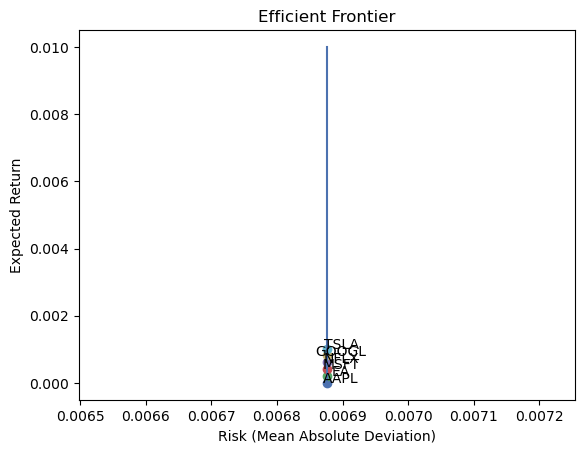

In [23]:
plt.figure()
plt.plot(risk_array, m0_array)

for i, stock in enumerate(assets):
    plt.annotate(
        stock,
        (risk_array[i], m0_array[i]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="center",
    )

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

### efficient frontier for 1xx Model

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/435e46e0affc4789a4afaf3f42867350-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/435e46e0affc4789a4afaf3f42867350-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 4287 RHS
At line 4792 BOUNDS
At line 4793 ENDATA
Problem MODEL has 504 rows, 257 columns and 3526 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
Perturbing problem by 0.001% of 0.025640236 - largest nonzero change 5.0298566e-06 ( 1.5138243%) - largest zero change 4.2496315e-06
0  Obj -0 Primal inf 0.1998573 (1)
31  Obj -0.00095410089 Primal inf 52.823225 (230)
83  Obj -0.0026479319 Primal inf 43.251197 (202)
134  Obj -0

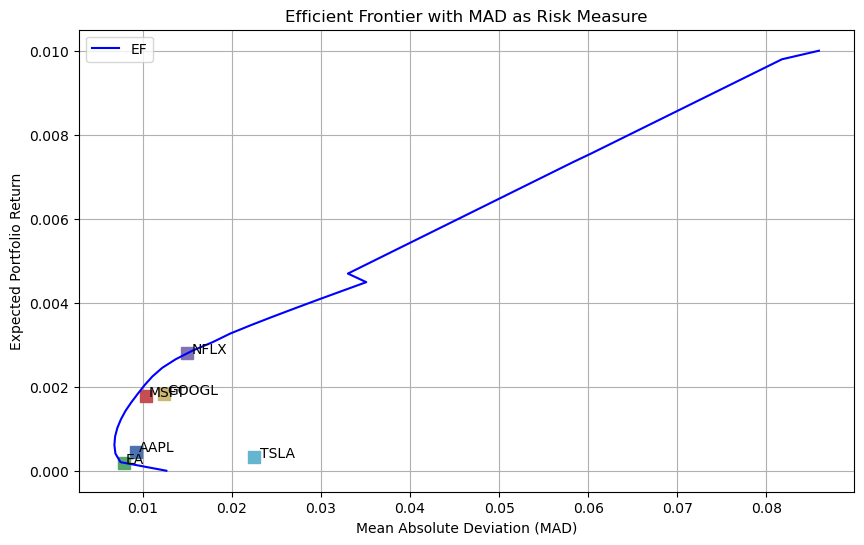

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from pulp import *

# Define the data
assets = ["AAPL", "EA", "MSFT", "NFLX", "GOOGL", "TSLA"]

# Fetch historical data for each asset and calculate daily returns
R = []
for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    close = df["Close"].values
    returns = (close[1:] - close[:-1]) / close[:-1]
    R.append(returns)

R = np.array(R).T

# Calculate mean return and mean absolute deviation for each asset
mean_return = np.mean(R, axis=0)
mean_absolute_deviation = np.mean(np.abs(R - mean_return), axis=0)

# Define the efficient frontier function
def efficient_frontier(R, assets):
    # Define the data
    n = len(assets)  # Number of assets
    T = len(R[:, 0])  # Number of time periods

    m0_array = np.linspace(0.0, 0.01, 50)
    risk_array = np.zeros_like(m0_array)
    portfolio_returns = []
    portfolio_mads = []

    for i, m0 in enumerate(m0_array):
        # Create a LP problem
        prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

        # Define decision variables
        x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
        y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

        # Define objective function
        prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

        # Define constraints
        for t in range(T):
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) <= y[t],
                f"Upper_constraint_{t}",
            )
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) >= -y[t],
                f"Lower_constraint_{t}",
            )

        prob += lpSum(mean_return[j] * x[j] for j in range(n)) == m0

        prob += lpSum(x) == 1, "Sum_of_weights"

        # Solve the problem
        prob.solve()
        
        # Calculate portfolio return and MAD
        portfolio_return = value(lpSum(mean_return[j] * x[j] for j in range(n)))
        portfolio_mad = value((1 / T) * lpSum(y[t] for t in range(T)))

        # Store portfolio return and MAD
        portfolio_returns.append(portfolio_return)
        portfolio_mads.append(portfolio_mad)

        # Store risk
        risk_array[i] = portfolio_mad
    
    return risk_array, portfolio_returns, portfolio_mads

# Calculate efficient frontier points
risk_array, portfolio_returns, portfolio_mads = efficient_frontier(R, assets)

# Fit a linear regression line to the efficient frontier points
slope, intercept, _, _, _ = stats.linregress(risk_array, portfolio_returns)
efficient_line = slope * risk_array + intercept

# Plot both plots on the same graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plot daily return versus mean absolute deviation
for i, asset in enumerate(assets):
    ax.plot(mean_absolute_deviation[i], mean_return[i], "s", ms=8)
    ax.text(mean_absolute_deviation[i] * 1.03, mean_return[i], asset)

#ax.set_xlim(0, 1.1 * np.max(mean_absolute_deviation))
#ax.axhline(0, color="r", linestyle="--")
ax.set_title("Daily return versus Mean Absolute Deviation")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

# Plot efficient frontier
#ax.plot(risk_array, efficient_line, label='Efficient Frontier Line', color='red')
ax.plot(portfolio_mads, portfolio_returns, color='blue', label='EF')
ax.set_xlabel('Mean Absolute Deviation (MAD)')
ax.set_ylabel('Expected Portfolio Return')
ax.legend()
plt.title('Efficient Frontier with MAD as Risk Measure')

plt.show()

# Now we consider risk as total variance of the portfolio, all these models are model 2x


Text(0.5, 1.0, 'Efficient Frontier')

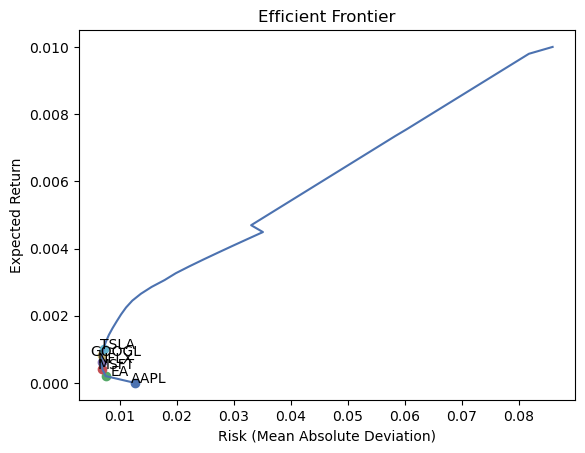

In [26]:
plt.figure()
plt.plot(risk_array, m0_array)

for i, stock in enumerate(assets):
    plt.annotate(
        stock,
        (risk_array[i], m0_array[i]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="center",
    )

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

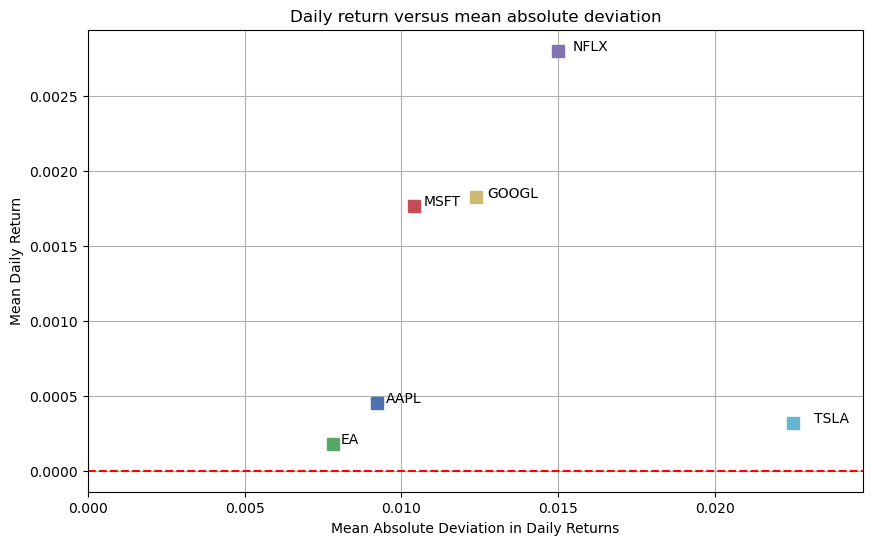

In [63]:
mean_return = np.mean(R, axis=0)
mean_absolute_deviation = np.mean(np.abs(R - mean_return), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, asset in enumerate(assets):
    ax.plot(mean_absolute_deviation[i], mean_return[i], "s", ms=8)
    ax.text(mean_absolute_deviation[i] * 1.03, mean_return[i], asset)

ax.set_xlim(0, 1.1 * np.max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Daily return versus mean absolute deviation")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

plt.show()


In [27]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
mu = 1
print(n, T, mu)

m0_array = np.linspace(0.0, 0.01, 50)
risk_array = 0.0 * m0_array
i = 0
for i in range(len(m0_array)):
    n = len(assets)  # Number of assets
    T = len(R[:, 0])  # Number of time periods
    mu = 1
    r0 = m0_array[i]

    # Create a LP problem
    prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

    # Define decision variables
    x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
    y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

    # Define objective function
    prob += (
        lpSum(r[j] * x[j] for j in range(n)) * mu
        - (1 / T) * lpSum(y[t] for t in range(T)),
        "Objective",
    )

    # Define constraints
    for t in range(T):
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
            f"Upper_constraint_{t}",
        )
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
            f"Lower_constraint_{t}",
        )

    prob += lpSum(x) == 1, "Sum_of_weights"

    # Solve the problem
    prob.solve()
    risk_array[i] = value((1 / T) * lpSum(y[t] for t in range(T)))

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

6 251 1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3e8edbf9e99e402fa306342744d23971-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/3e8edbf9e99e402fa306342744d23971-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 508 COLUMNS
At line 4286 RHS
At line 4790 BOUNDS
At line 4791 ENDATA
Problem MODEL has 503 rows, 257 columns and 3520 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 443 (-60) rows, 257 (0) columns and 3100 (-420) elements
Perturbing problem by 0.001% of 0.027176074 - largest nonzero change 8.1771298e-05 ( 15.100142%) - largest zero change 0
0  Obj -0 Primal inf 0.19985628 (1) Dual inf 0.05381411 (6)
48  Obj -0.00018652906 Primal inf 361.31849 (215)
94  Obj -0.0019359769 Primal inf 94.366147 (199)
144  Obj -0.0035384863 Primal inf 179.9078 (187)


Text(0.5, 1.0, 'Efficient Frontier')

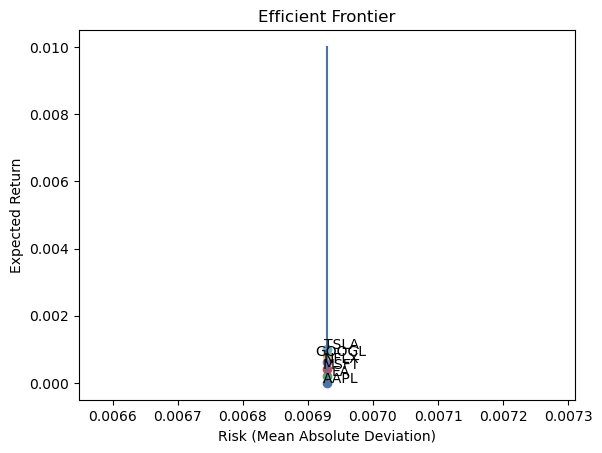

In [28]:
plt.figure()
plt.plot(risk_array, m0_array)

for i, stock in enumerate(assets):
    plt.annotate(
        stock,
        (risk_array[i], m0_array[i]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="center",
    )

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

# model 2A
when we minimize variance under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left(\sum_j x_j\left(R_j(t)-r_j\right)\right)^2 \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

In [29]:
# centered return
R_c = 0.0 * R
for j in range(len(R[0, :])):
    R_c[:, j] = R[:, j] - r[j]

# print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0.0 * S
for i in range(len(R[:, 0])):
    sig = sig + np.outer(R_c[i, :], R_c[i, :])
sig = sig / T


r0 = 0.0005
n = len(R[0, :])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

X = cp.Variable((n, 1))
Objective = cp.Minimize(cp.quad_form(X, sig))
constraints = [e.T @ X == 1, X >= 0, rq.T @ X >= r0]
problem = cp.Problem(Objective, constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0])
print("Mean variance:", (X.value.T @ sig @ X.value)[0])
X

expected portfolio [[ 2.40270103e-01  4.92686667e-01  1.79555127e-01  1.78598086e-02
   6.96282945e-02 -1.59965275e-19]]
expected return : [0.00069283]
Mean variance: [8.22897213e-05]


Variable((6, 1), var1)

### Model 2B

In [30]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T


v0 = 0.0003
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(rq.T@X)
constraints = [e.T@X == 1, X >= 0, cp.quad_form(X,sig) <= v0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )


expected portfolio [[9.60176906e-08 9.23657248e-08 1.49585706e-01 6.79491906e-01
  1.70922123e-01 7.64974240e-08]]
expected return : [0.00248111]
Mean variance: [0.0003]
Mean std: [0.01732051]


/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


### Model 2C

In [31]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

mu = 0.1
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(mu * rq.T@X - cp.quad_form(X,sig))
constraints = [e.T@X == 1, X >= 0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )

expected portfolio [[8.63746074e-24 1.60678312e-01 4.17398475e-01 2.02295941e-01
  2.19627273e-01 5.07037680e-24]]
expected return : [0.00173551]
Mean variance: [0.00013053]
Mean std: [0.01142496]


Text(0.5, 1.0, 'Efficient Frontier')

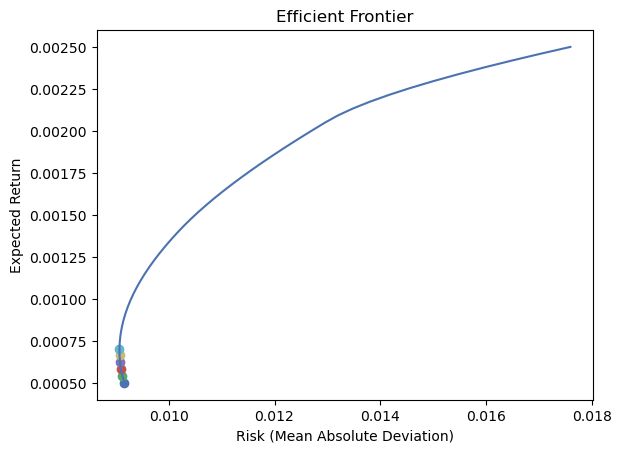

In [32]:
### Efficient Frontier
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
e = np.ones((n,1))
rq = r.reshape(n,1)

m0_array = np.linspace(0.0005,0.0025,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  r0 = m0_array[i]

  X = cp.Variable((n,1))
  Objective = cp.Minimize(cp.quad_form(X,sig))
  constraints = [e.T@X == 1, X >= 0, rq.T@X == r0]
  problem = cp.Problem(Objective,constraints)

  result = problem.solve()

  risk_array[i] = (X.value.T @ sig @ X.value)[0,0]**0.5

#print("Status:", LpStatus[prob.status])
#print("Optimal Portfolio Weights:")
#for j in range(n):
    #print(f"x{j}: {value(x[j])}")
#print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
#print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))

plt.figure()
plt.plot(risk_array,m0_array)

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

## Optimization Problem

Choose a risk tolerance $q > 0$:

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} - q \mathbf{r}^T \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{x} \geq 0 \\
\end{align*}

In [33]:
n = len(assets)
q = 0.1
e = np.ones(n)
X = cp.Variable(n)

obj = cp.Minimize(cp.quad_form(X, S) - q * r @ X)
constraints = [e @ X == 1, X >= 0]
problem = cp.Problem(obj, constraints)


result = problem.solve()
X.value

array([-1.19599402e-22,  1.62353006e-01,  4.16757469e-01,  2.01641765e-01,
        2.19247760e-01, -8.03821665e-24])

In [34]:
r

array([0.00045349, 0.00018063, 0.00176909, 0.00280256, 0.00182639,
       0.00032046])

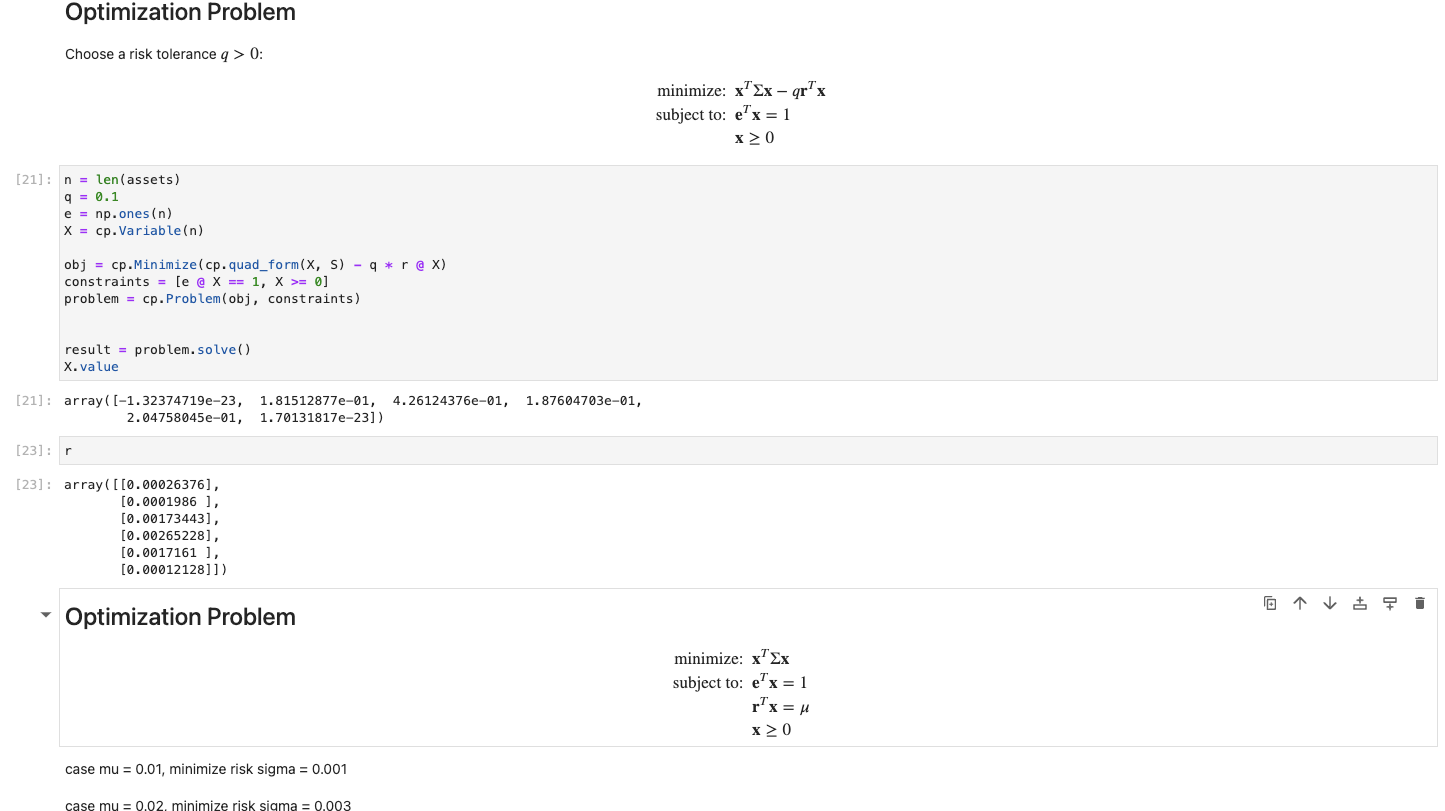## Optimization Problem

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{r}^T \mathbf{x} = \mu \\
& \mathbf{x} \geq 0 \\
\end{align*}

case mu = 0.01,   minimize risk sigma = 0.001

case mu = 0.02,  minimize risk sigma = 0.003

case mu = 0.05,  minimize risk  sigma = 0.010



In [35]:
n = len(assets)
e = np.ones((n, 1))
r = r.reshape(n, 1)
mu = 0.001

M = np.block([[2 * S, -r, -e], [r.T, 0, 0], [e.T, 0, 0]])
b = np.block([[np.zeros((n, 1))], [mu], [1]])

x = la.solve(M, b)
print(x)

[[ 1.62052237e-01]
 [ 4.35413279e-01]
 [ 2.53737170e-01]
 [ 6.78983673e-02]
 [ 1.21362517e-01]
 [-4.04635705e-02]
 [ 2.49037625e-02]
 [ 1.45919838e-04]]


In [37]:
import pandas as pd
import yfinance as yf

T = 1  # Number of days in time period
assets = ["AAPL", "EA", "MSFT", "NFLX", "GOOGL", "TSLA"]

# Initialize a dictionary to store stock prices
prices_dict = {}

# Loop through each stock and retrieve prices
for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    prices_dict[stock] = df["Close"]

# Create a DataFrame from the prices dictionary
df_prices = pd.DataFrame(prices_dict)

# Display the DataFrame
print(df_prices.head())

                                 AAPL          EA        MSFT        NFLX  \
Date                                                                        
2023-04-12 00:00:00-04:00  159.250000  125.400902  281.182251  331.029999   
2023-04-13 00:00:00-04:00  164.680969  127.538475  287.480560  346.190002   
2023-04-14 00:00:00-04:00  164.332840  127.130844  283.810699  338.630005   
2023-04-17 00:00:00-04:00  164.352737  127.339622  286.449005  332.720001   
2023-04-18 00:00:00-04:00  165.586166  128.294083  286.022491  333.700012   

                                GOOGL        TSLA  
Date                                               
2023-04-12 00:00:00-04:00  104.639999  180.539993  
2023-04-13 00:00:00-04:00  107.430000  185.899994  
2023-04-14 00:00:00-04:00  108.870003  185.000000  
2023-04-17 00:00:00-04:00  105.970001  187.039993  
2023-04-18 00:00:00-04:00  104.500000  184.309998  


In [38]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df_prices)
S = CovarianceShrinkage(df_prices).ledoit_wolf()

In [39]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [40]:
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('AAPL', 0.0), ('EA', 0.0), ('MSFT', 0.39752), ('NFLX', 0.3737), ('GOOGL', 0.22878), ('TSLA', 0.0)])


In [41]:
ret_optimal, vol_optimal, sharpe_ration = ef.portfolio_performance(verbose=True)

Expected annual return: 66.7%
Annual volatility: 21.6%
Sharpe Ratio: 3.00


In [42]:
from pypfopt import EfficientFrontier
ef_curve = EfficientFrontier(mu, S, weight_bounds = (0,1))
ef_curve

/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


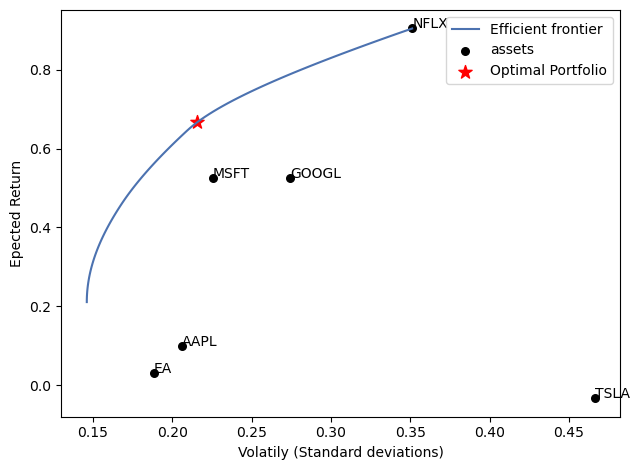

In [43]:
from pypfopt import plotting
fig,ax = plt.subplots()
plotting.plot_efficient_frontier(ef_curve, ax=ax, show_assets = True)

ax.scatter(vol_optimal, ret_optimal, marker = "*", s=100, c="r", label = "Optimal Portfolio")

for i, txt in enumerate(ef.tickers):
    ax.annotate(txt, ((np.diag(ef.cov_matrix) ** (1/2))[i], ef. expected_returns[i]))
    
    
ax.set_xlabel("Volatily (Standard deviations)")
ax.set_ylabel("Epected Return")
ax.legend()
plt.show()